# Mass Balance ($\dot{b}$) and Air Termperature Coupling ($T$)

In order to find glacier of the correct size we must prescribe mass balance anomolies $\Delta \dot{b}$ to the KMR data. We follow _Cuffey and Paterson_ (2010) in making a linear approximation such that: 

$$
\begin{equation} \label{eqn:MB_sens_full}
    \Delta \dot{b} = \frac{\partial \dot{b}}{\partial T} \, \Delta T +
                     \frac{\partial \dot{b}}{\partial P} \, \Delta P + \ldots
\end{equation}
$$
where $ \frac{\partial \dot{b}}{\partial T}$ & $\frac{\partial \dot{b}}{\partial P}$ are the local mass balance sensivities to temperature and precipitation, $\Delta T$ & $ \Delta P$  are the temperature and percipitation anomolies, and "$\ldots$" includes additional variables like cloud cover, wind speed, and humidity (_Cuffey and Paterson_ 2010; pg. 106). Given our simplified approach to prescribing the next balance, we only consider the first term on the r.h.s. of the equation above. 

In this notebook we seek to: 

1. Determine a value for  $ \frac{\partial \dot{b}}{\partial T}$ from the KMR mass balance data
2. Asses whether local mass balance sensivities suffice, or if we need to use the glacier wide values

In [1]:
import sys
import numpy as np
import xarray as xr
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Set global matplotlib style parameters
plt.rcParams.update({'text.usetex': True})

# class for having a custom diverging colormap
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

    def inverse(self, value):
        y, x = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]

## Load and Clean the Kaskawulsh Data

We will use the KMR result from the Kaskawulsh to determine the mass balance sensivity

In [2]:
# File path to the full KMR data
nc_fp = "/Users/andrewnolan/Library/CloudStorage/OneDrive-SimonFraserUniversity(1sfu)/KMR_debrisfree_NetBalance/Kaskawulsh_NetBalance_with_DailyTemp.nc"

# load the NetCDF file and preview
MB_new = xr.open_dataset(nc_fp)

We need to extra numpy arrays, since scipy can not opeate on xarray datasets

In [3]:
# Let's subset the data we need, and extra as numpy array
z = MB_new.stack(z=('x', 'y')).Z.values
b = MB_new.stack(z=('x', 'y')).B.values
T = MB_new.stack(z=('x', 'y')).Temp.mean('time').values

# calculat the mean annual air temp at z_ref = mean elevation
T_ma = MB_new.Temp.mean()

Now let's remove all the `nan`s from our data, and sort the dependent variable.
The sorting step is necessary for the `scipy` interpolation schemes. 

In [4]:
# find indexes of nans and sort indexes
mask = np.where(~np.isnan(z))
idxs = np.argsort(z[mask])

# Remove the nans and sort the data and downsample data so there are
# less verically overlappig points, causing the spline fitting to fail
z_sub = z[~np.isnan(z)]
b_sub = b[~np.isnan(z)]
T_sub = T[~np.isnan(z)]

# Sort the data based on Temperature, since it's out dependent variable 
idxs   = np.argsort(T_sub, kind='heapsort')
z_     = z_sub[idxs]
b_     = b_sub[idxs]
T_     = T_sub[idxs]

## Determine $\frac{\partial \dot{b}}{\partial T}$

Next, lets create to new set of vectors which we will use to evaluate the fitted functions 

In [5]:
# create an evenly spaced vector across air temp
T_full = np.linspace(T_.min(), T_.max(), 1000)
z_full = np.linspace(z_.min(), z_.max(), 1000)
# assign an abritary length to the Kaskawulsh
x_full = np.linspace(0, 20e3, 1000)

First we will fit a simple first order polynomial for the data. 
This approach assumes a constant mass balance sensitivity $\frac{\partial \dot{b}}{\partial T}$ for all elevations, such that 
$$
\begin{equation}
\Delta \dot{b} = \frac{\partial \dot{b}}{\partial T} \Delta T
\end{equation}
$$
where $\Delta \dot{b}$ is the mass balance anomoly and $\Delta T$ is the temperature anomoly, per equation 4.8 of Cuffey and Paterson (pg. 106). 

In [6]:
# fit a first order polynomial to the data
p = np.polyfit(T_, b_, 1)
# evalute the polynomial 
poly_1 = np.polyval(p, T_full)

# extract the slope from the least squares fitting
dbdT_linear = p[0]

Next lets fit a spline to the mass balance data as a function of elevation. 

In [7]:
# fit a spline to the data
tck    = interpolate.splrep(T_[::10], b_[::10], w=None, k=5, s=111)
# evaluate the spline 
spline = interpolate.splev(T_full, tck)

This allow us to find the local, in our case elevation dependent, mass balance sensivities $\frac{\partial \dot{b}(T(z))}{\partial T(z)}$. 

Following Equations 4.9 and 4.10 from Cuffey and Paterson (pg. 107), we define the glacier wide mass balance sensivities ($\Delta \bar{\dot{b}}$) as 
$$
\begin{equation}
\Delta \bar{\dot{b}} = C_{\rm T} \Delta T
\end{equation}
$$

where 
$$
\begin{equation}
C_{\rm T} =\frac{1}{\mathcal{A}} \int_{\mathcal{A}} \frac{\partial \dot{b}}{\partial T} d\mathcal{A}
\end{equation}
$$

Due to constant gridcell spacing in the single horizontal dimension ($x$), the integral above is equivalent to the average of the elevation dependent $\frac{\partial \dot{b}}{\partial T}$. 

In [8]:
# find the elevation dependent mass balance sensitivty for the slpine 
dbdT_spline = np.gradient(spline, T_full)

# Find the glacier wide, mass balance sensivity 
C_T = np.trapz(dbdT_spline, x_full) / (x_full.max() - x_full.min())

# using the slope calculated above, evaluate the other linear method
spline_p_1 = np.array([C_T, -C_T*T_ma])
spline_poly_1 = np.polyval(spline_p_1, T_full)

Now let's see how different the two different methods are by calculating the percent differecne

In [9]:
# calculate the percent difference b/w the two methods
diff = (C_T - dbdT_linear)/(dbdT_linear) * 100 

print(f"{diff:1.1f} % difference between the two methods")

3.7 % difference between the two methods


## Visualization

Finally, let's visualize the results 

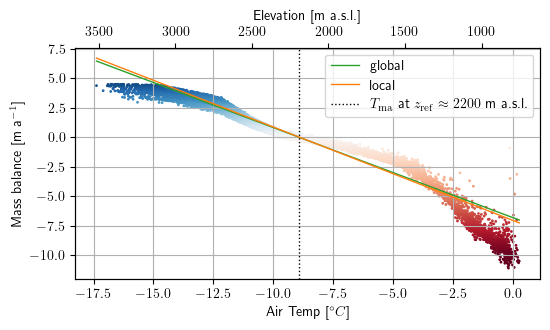

In [10]:
fig, ax = plt.subplots(figsize=(6, 3))

# create the special diverging color map
midnorm = MidpointNormalize(vmin=-10., vcenter=0, vmax=5)

ax2 = ax.twiny()
ax2.invert_xaxis()

# plot the data
ax2.scatter(z_, b_, c=b_, s=1.0, cmap='RdBu', norm=midnorm)
ax.plot(T_full, poly_1, c='tab:green', lw=1.0, label='global')
# ax.plot(T_full, spline, c='tab:orange', lw=1.0, label='spline')
ax.plot(T_full, spline_poly_1, c='tab:orange', lw=1.0, label='local')

ax.axvline(MB_new.Temp.mean(), c='k', ls=":", lw=1.0, label='$T_{\\rm ma}$ at $z_{\\rm ref} \\approx  2200 $ m a.s.l.')

# add some labels
ax.set_ylabel('Mass balance [m a$^{-1}$]')
ax.set_xlabel(r'Air Temp [$^\circ C$]')
ax2.set_xlabel(r'Elevation [m a.s.l.]')
ax.grid()

ax.zorder = 2 # then the line
ax2.zorder = 1 # then the points

# need to make facecolor transparent
ax.set_facecolor([0.0, 0.0, 0.0, 0.0])
ax.legend()

# Wrapping Up 

From the work above, we concluded: 

1. $\frac{\partial \dot{b}}{\partial T} \approx -0.77$ [m a$^{-1}$ C$^{-1}$]
2. the global linear approximation is sufficent for our purposes. Is only 3% different than the more complete method